In [2]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [3]:
from google.colab import files
d = files.upload()

Saving merged_sales_data.csv to merged_sales_data.csv


In [4]:
df = pd.read_csv('merged_sales_data.csv')

In [5]:
df.shape

(186850, 6)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186850 entries, 0 to 186849
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Order ID          186305 non-null  object
 1   Product           186305 non-null  object
 2   Quantity Ordered  186305 non-null  object
 3   Price Each        186305 non-null  object
 4   Order Date        186305 non-null  object
 5   Purchase Address  186305 non-null  object
dtypes: object(6)
memory usage: 8.6+ MB


In [7]:
df.isnull().sum()

,0
Order ID,545
Product,545
Quantity Ordered,545
Price Each,545
Order Date,545
Purchase Address,545


In [8]:
df = df.dropna()

In [9]:
df.isnull().sum()

,0
Order ID,0
Product,0
Quantity Ordered,0
Price Each,0
Order Date,0
Purchase Address,0


In [10]:
df["Quantity Ordered"] = pd.to_numeric(df["Quantity Ordered"], errors="coerce")
df["Price Each"] = pd.to_numeric(df["Price Each"], errors="coerce")

In [11]:
df["Order Date"] = pd.to_datetime(df["Order Date"], errors="coerce")

<ipython-input-11-b7526dc4d4da>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Order Date"] = pd.to_datetime(df["Order Date"], errors="coerce")


In [12]:
df = df.dropna(subset=["Order Date"]) #Remove Invalid date

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 185950 entries, 0 to 186849
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Order ID          185950 non-null  object        
 1   Product           185950 non-null  object        
 2   Quantity Ordered  185950 non-null  float64       
 3   Price Each        185950 non-null  float64       
 4   Order Date        185950 non-null  datetime64[ns]
 5   Purchase Address  185950 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 9.9+ MB


In [14]:
df["Month"] = df["Order Date"].dt.to_period("M")

<ipython-input-14-f1b195d6feb3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Month"] = df["Order Date"].dt.to_period("M")


In [15]:
df = df.drop(columns=["Order ID", "Product","Purchase Address"])

In [16]:
df["Total Price"] = df["Quantity Ordered"] * df["Price Each"]

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 185950 entries, 0 to 186849
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Quantity Ordered  185950 non-null  float64       
 1   Price Each        185950 non-null  float64       
 2   Order Date        185950 non-null  datetime64[ns]
 3   Month             185950 non-null  period[M]     
 4   Total Price       185950 non-null  float64       
dtypes: datetime64[ns](1), float64(3), period[M](1)
memory usage: 8.5 MB


In [18]:
monthly_sales = df.groupby(df["Order Date"].dt.to_period("M"))["Total Price"].sum()

In [19]:
monthly_sales.index = monthly_sales.index.to_timestamp()

In [20]:
decomposition = seasonal_decompose(monthly_sales, model="additive", period=6)

In [21]:
trend = decomposition.trend

In [22]:
trend

,trend
Order Date,
2019-01-01,NaN
2019-02-01,NaN
2019-03-01,NaN
2019-04-01,2.726814e+06
2019-05-01,2.799867e+06
2019-06-01,2.744276e+06
2019-07-01,2.713985e+06
2019-08-01,2.746740e+06
2019-09-01,2.920293e+06


In [23]:
season = decomposition.seasonal

In [24]:
season

,seasonal
Order Date,
2019-01-01,7066.795625
2019-02-01,-428995.508542
2019-03-01,-749456.386042
2019-04-01,838565.851875
2019-05-01,426016.252292
2019-06-01,-93197.005208
2019-07-01,7066.795625
2019-08-01,-428995.508542
2019-09-01,-749456.386042


In [25]:
residual = decomposition.resid

In [26]:
residual

,resid
Order Date,
2019-01-01,NaN
2019-02-01,NaN
2019-03-01,NaN
2019-04-01,-174709.470208
2019-05-01,-73276.258958
2019-06-01,-73276.258958
2019-07-01,-73276.258958
2019-08-01,-73276.258958
2019-09-01,-73276.258958


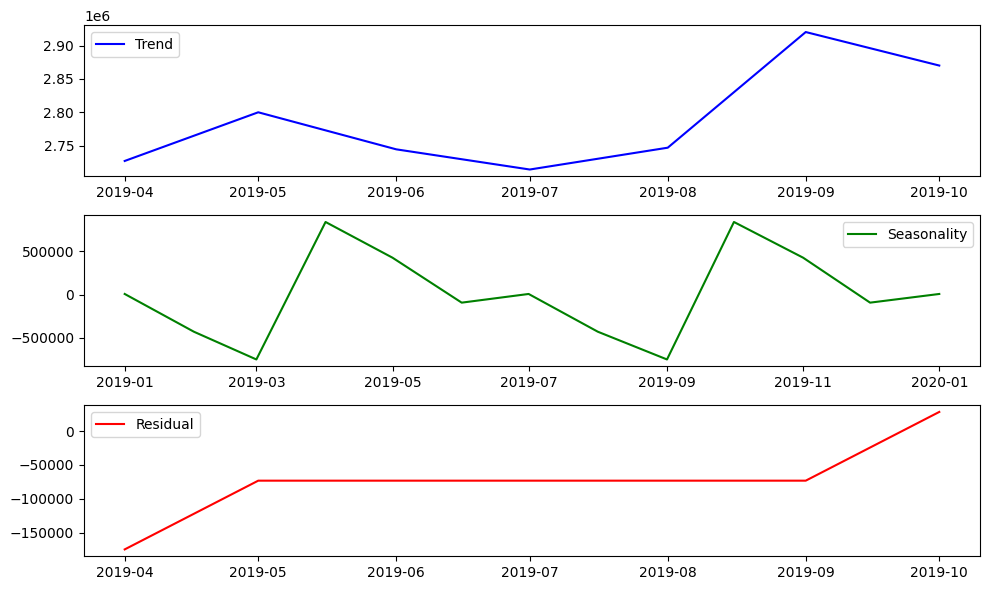

In [27]:
# Plot the decomposition
plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)
plt.plot(trend, label="Trend", color="blue")
plt.legend(loc="best")

plt.subplot(3, 1, 2)
plt.plot(season, label="Seasonality", color="green")
plt.legend(loc="best")

plt.subplot(3, 1, 3)
plt.plot(residual, label="Residual", color="red")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [28]:
# Perform ADF test
adf_test = adfuller(monthly_sales)
print("ADF Test Statistic:", adf_test[0])
print("p-value:", adf_test[1])

ADF Test Statistic: -4.641661671708135
p-value: 0.00010815867488356096


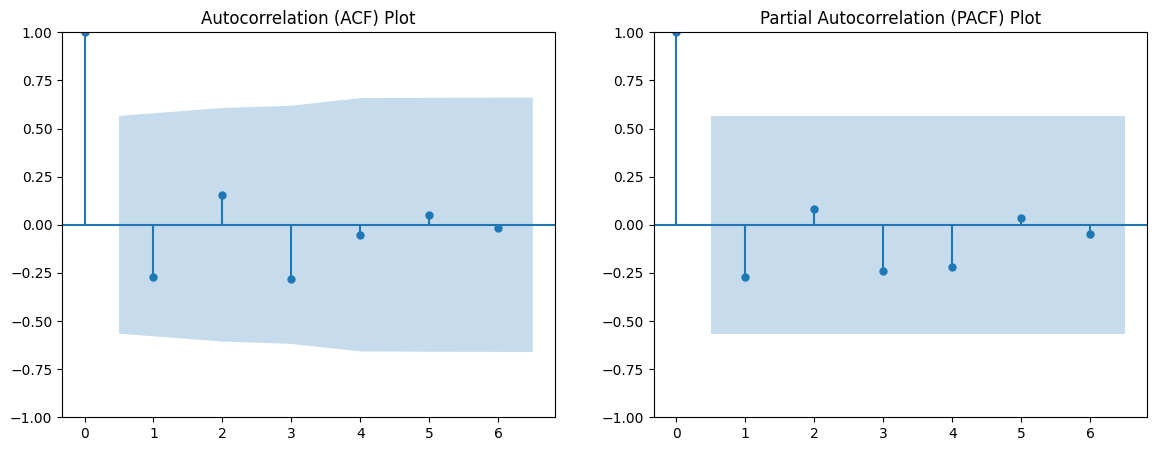

In [29]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(monthly_sales.diff().dropna(), ax=axes[0], lags=6)
plot_pacf(monthly_sales.diff().dropna(), ax=axes[1], lags=6)
axes[0].set_title("Autocorrelation (ACF) Plot")
axes[1].set_title("Partial Autocorrelation (PACF) Plot")
plt.show()

In [30]:
# Fit ARIMA(1,1,1) model (p,d,q), here p_value is less than 0.05 hence the data is in stationary so set d=0
arima_model = ARIMA(monthly_sales, order=(1,0,1))
arima_result = arima_model.fit()
print(arima_result)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [31]:
# Forecast next 2 month
forecast = arima_result.forecast(steps=1)

<ipython-input-32-2fbdf8b637a1>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(start=monthly_sales.index[-1] + pd.DateOffset(months=1),


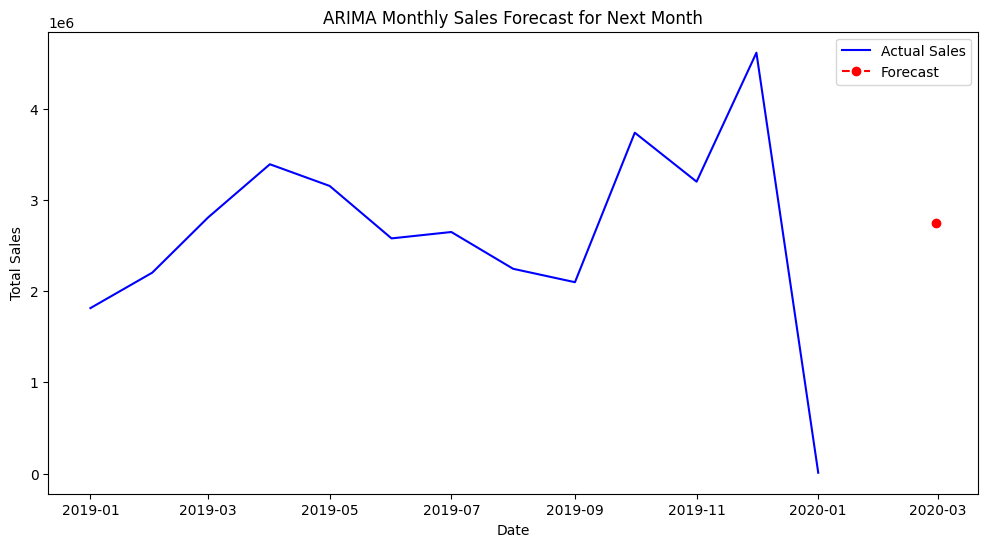

In [32]:

# Ensure forecast dates align with actual sales
forecast_dates = pd.date_range(start=monthly_sales.index[-1] + pd.DateOffset(months=1),
                               periods=1, freq="M")

# Plot actual sales
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, label="Actual Sales", color="blue")

# Plot forecast with correct dates
plt.plot(forecast_dates, forecast, label="Forecast", linestyle="dashed", color="red", marker='o')

plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.title("ARIMA Monthly Sales Forecast for Next Month")
plt.legend()
plt.show()
